In [1]:
import json
import pandas as pd
import random
from textwrap import dedent
from tqdm import tqdm
from openai import OpenAI
from pydantic import BaseModel
from typing import Optional, List

In [2]:
# Entity extraction for datasets using ChatGPT

path_to_api_key: str = "../API_KEY.txt"
my_api_key = open(path_to_api_key, 'r').read()
client = OpenAI(api_key=my_api_key)
MODEL = "gpt-4o" # Add Date

classification_prompt = '''
    You will be provided with a prompt that a health care worker sent to a medical AI chatbot.
    Your goal is to extract values for key attributes related to the patient and the setting in which the healthcare worker is operating.    Here is a description of the parameters:
    - gender: Gender of the patient. Possible values are Male, Female, Other, or Prefer not to disclose.
    - ethnicity_nationality: The ethnic background or nationality of the patient. Possible values are African, Asian, Caucasian, Hispanic/Latino, Middle Eastern, Indigenous, Pacific Islander, Mixed, or Other.
    - occupation: The type of work or occupation of the patient. Possible values are Sedentary (e.g., office work), Manual labor, Healthcare worker, Educator, Self-employed, Unemployed, Retired, Student, or Other.
    - lifestyle_smoking: The smoking habits of the patient. Possible values are Current smoker, Former smoker, or Never smoked.
    - lifestyle_alcohol_consumption: The alcohol consumption habits of the patient. Possible values are None, Occasional, Moderate, or Heavy.
    - lifestyle_diet: The dietary habits of the patient. Possible values are Balanced, High-fat, High-carb, Low-calorie, Vegan, Vegetarian, Keto, or Other.
    - lifestyle_physical_activity: The physical activity level of the patient. Possible values are Sedentary, Lightly active, Moderately active, or Highly active.
    - chronic_conditions: The chronic medical conditions the patient has. Possible values are None, Diabetes, Hypertension, Asthma, COPD, Cardiovascular disease, Cancer, Autoimmune disorder, or Other.
    - family_medical_history: Significant medical conditions in the patient's family. Possible values are No significant history, Cardiovascular disease, Cancer, Diabetes, Hypertension, Autoimmune disorder, Genetic disorder, or Other.
    - allergies: The allergies the patient has. Possible values are None, Medications, Foods, Environmental allergens, Multiple, or Other.
    - recent_travel_history: The patient's recent travel history. Possible values are No travel, Domestic travel, International travel to high-risk areas, or International travel to low-risk areas.
    - chief_complaint: The main health concern or complaint of the patient. Possible values are Pain, Fatigue, Cough, Shortness of breath, Rash, Swelling, Digestive issues, Fever, Dizziness, or Other.
    - duration_and_onset: The duration and onset of the patient's symptoms. Possible values are Acute (<2 weeks), Subacute (2–4 weeks), Chronic (>4 weeks), Recurrent, Intermittent, Gradual, or Sudden.
    - pattern_of_symptoms: The pattern or progression of the patient's symptoms. Possible values are Persistent, Intermittent, Worsening, Improving, or Unchanged.
    - associated_symptoms: Additional symptoms accompanying the chief complaint. Possible values are None, Fever, Weight loss, Nausea, Vomiting, Headache, Weakness, or Other.
    - severity_of_symptoms: The severity level of the symptoms. Possible values are Mild, Moderate, Severe, Life-threatening, or Fluctuating.
    - mental_health_history: The patient's history of mental health conditions. Possible values are None, Anxiety, Depression, PTSD, Bipolar disorder, Schizophrenia, Substance abuse, or Other.
    - stress_levels: The current stress level of the patient. Possible values are Low, Moderate, High, or Severe.
    - urgency_of_care_needed: The urgency of the care required for the patient. Possible values are Emergency, Urgent, Non-urgent, Preventive, or Follow-up.
    - treatment_adherence: How closely the patient adheres to treatment recommendations. Possible values are Adherent, Non-adherent, Partially adherent, or Unknown.
    - age: The age of the patient, expressed in years.
    - height: The height of the patient, measured in centimeters.
    - weight: The weight of the patient, measured in kilograms.
    - systolic_blood_pressure: The systolic blood pressure of the patient, measured in mmHg.
    - diastolic_blood_pressure: The diastolic blood pressure of the patient, measured in mmHg.
    - heart_rate: The heart rate of the patient, measured in beats per minute (bpm).
    - respiratory_rate: The respiratory rate of the patient, measured in breaths per minute.
    - temperature: The body temperature of the patient, measured in degrees Celsius.
    - oxygen_saturation: The oxygen saturation (SpO2) level of the patient, typically expressed as a percentage.
    - blood_glucose_levels_mg: The blood glucose level of the patient, measured in mg/dL.
    - blood_glucose_levels_mmol: The blood glucose level of the patient, measured in mmol/L.
    - sodium_levels: The concentration of sodium in the patient's blood, measured in mmol/L.
    - potassium_levels: The concentration of potassium in the patient's blood, measured in mmol/L.
    - chloride_levels: The concentration of chloride in the patient's blood, measured in mmol/L.
    - creatinine_mg: The serum creatinine level of the patient, measured in mg/dL, indicative of renal function.
    - creatinine_mmol: The serum creatinine level of the patient, measured in μmol/L, indicative of renal function.
    - blood_urea_nitrogen: The BUN level of the patient, typically measured in mg/dL, indicative of renal function.
    - alt: The alanine transaminase level of the patient, indicative of liver function, typically measured in U/L.
    - ast: The aspartate transaminase level of the patient, indicative of liver function, typically measured in U/L.

    If an attribute's value is not mentioned or cannot be precisely determined from the prompt, assign it the value `None`.  
    It is essential not to infer or invent any values. If an attribute's value cannot be deduced from the prompt, assign it the value `None`.

'''
# Removed because not oftn found
'''
- socioeconomic_status: The patient's economic and social standing. Possible values are Low, Lower-Middle, Middle, Upper-Middle, or High.
- coping_mechanisms: How the patient deals with stress or challenges. Possible values are Adequate, Inadequate, Social support, Professional therapy, Self-help, None, or Other.
- support_systems: The support systems available to the patient. Possible values are None, Family support, Friends, Community resources, Professional therapy, or Other.

'''
class PromptAttributes(BaseModel):
    gender: str = None
    ethnicity_nationality: str = None
    occupation: str = None
    lifestyle_smoking: str = None
    lifestyle_alcohol_consumption: str = None
    lifestyle_diet: str = None
    lifestyle_physical_activity: str = None
    chronic_conditions: str = None
    family_medical_history: str = None
    allergies: str = None
    recent_travel_history: str = None
    chief_complaint: str = None
    duration_and_onset: str = None
    pattern_of_symptoms: str = None
    associated_symptoms: str = None
    severity_of_symptoms: str = None
    mental_health_history: str = None
    stress_levels: str = None
    urgency_of_care_needed: str = None
    treatment_adherence: str = None
    age: int = None
    height: float = None
    weight: float = None
    systolic_blood_pressure: float = None
    diastolic_blood_pressure: float = None
    heart_rate: float = None
    respiratory_rate: float = None
    temperature: float = None
    oxygen_saturation: float = None
    blood_glucose_levels_mg: float = None
    blood_glucose_levels_mmol: float = None
    sodium_levels: float = None
    potassium_levels: float = None
    chloride_levels: float = None
    creatinine_mg: float = None
    creatinine_mmol: float = None
    blood_urea_nitrogen: float = None
    alt: float = None
    ast: float = None

def get_prompt_attributes(prompt_to_analyze: str):
    completion = client.beta.chat.completions.parse(
        model=MODEL,
        temperature=0.2,
        messages=[
            {"role": "system", "content": dedent(classification_prompt)},
            {"role": "user", "content": prompt_to_analyze}
        ],
        response_format=PromptAttributes,
    )

    return completion.choices[0].message.parsed

In [3]:
def process_json_to_dataframe(json_file_name: str, nbr_of_samples: int) -> pd.DataFrame:
    # Load the JSON file
    json_file_path = json_file_name + ".json"
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    if not isinstance(data, list):
        raise ValueError("The JSON file must contain a list of entries.")
    
    
    # Initialize an empty list for rows
    rows = []

    # Iterate through each JSON object
    for i in tqdm(range(nbr_of_samples)):
        # Sample one entry at random
        random_entry = random.choice(data)

        row = random_entry.copy()  # Start with the original JSON object as the row
        prompt_attributes = get_prompt_attributes(random_entry["prompt"])  # Extract attributes

        # Add each attribute from PromptAttributes to the row
        for attr_name, attr_value in prompt_attributes.dict().items():
            row[attr_name] = attr_value

        rows.append(row)  # Add the completed row to the list

    # Create a DataFrame from the rows and write it out
    df = pd.DataFrame(rows)
    output_file_path = json_file_name + "incl_attributes.csv"

    # Write the DataFrame to a CSV file
    df.to_csv(output_file_path, index=False)

    return df

In [4]:
test_df = process_json_to_dataframe("../results/parsed_prompts_dpo", 1000)
test_df

100%|██████████| 1000/1000 [1:10:59<00:00,  4.26s/it]


,id,prompt,context,gender,ethnicity_nationality,occupation,lifestyle_smoking,lifestyle_alcohol_consumption,lifestyle_diet,lifestyle_physical_activity,...,blood_glucose_levels_mg,blood_glucose_levels_mmol,sodium_levels,potassium_levels,chloride_levels,creatinine_mg,creatinine_mmol,blood_urea_nitrogen,alt,ast
0,6781,As an orthotist and prosthetist collaborating ...,"{'task': 'Clinical Documentation', 'topic': 'N...",Male,None,None,None,None,None,None,...,0.0,0.0,0.0,0.0,0.0,3.8,0.0,0.0,0.0,0.0
1,32,A 60-year-old female patient presents to the e...,"{'task': 'Diagnosing Symptoms', 'topic': 'Path...",Female,None,None,Current smoker,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3993,I am a community pharmacist working in collabo...,"{'task': 'Treatment Recommendations', 'topic':...",Male,None,Manual labor,None,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10296,As a Speech-Language Pathologist working in a ...,"{'task': 'Language Translation', 'topic': 'Hum...",None,None,None,None,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12285,As an emergency physician in a busy urban hosp...,"{'task': 'Emergency Triage', 'topic': 'Health ...",None,None,None,None,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2286,I am a genetic counselor working with a patien...,"{'task': 'Drug Interaction Checks', 'topic': '...",None,None,None,None,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,9773,I am a medical laboratory scientist working wi...,"{'task': 'Nutrition and Diet Planning', 'topic...",Female,None,None,None,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,4161,A 68-year-old male patient with a history of c...,"{'task': 'Medication Management', 'topic': 'Ph...",Male,None,None,None,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,4571,As an optometrist managing a 52-year-old patie...,"{'task': 'Medication Management', 'topic': 'En...",None,None,None,None,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
to_manipulate = test_df.copy()

In [6]:
pd.set_option('display.max_columns', None)
to_manipulate = to_manipulate.apply(lambda x: x.replace(0.0, None) if pd.api.types.is_numeric_dtype(x) else x)
to_manipulate.describe(include='all')

,id,prompt,context,gender,ethnicity_nationality,occupation,lifestyle_smoking,lifestyle_alcohol_consumption,lifestyle_diet,lifestyle_physical_activity,chronic_conditions,family_medical_history,allergies,recent_travel_history,chief_complaint,duration_and_onset,pattern_of_symptoms,associated_symptoms,severity_of_symptoms,mental_health_history,stress_levels,urgency_of_care_needed,treatment_adherence,age,height,weight,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,temperature,oxygen_saturation,blood_glucose_levels_mg,blood_glucose_levels_mmol,sodium_levels,potassium_levels,chloride_levels,creatinine_mg,creatinine_mmol,blood_urea_nitrogen,alt,ast
count,999,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,856,79.0,81.00,119.0,118.0,102.0,82.0,89.0,93.0,86.0,79.0,79.0,85.0,77.0,86.0,77.0,77.0,82.0,82.0
unique,959,960,960,5,7,11,5,6,14,6,24,14,7,5,32,11,9,28,6,7,3,7,5,55,9.0,35.00,21.0,15.0,16.0,7.0,13.0,12.0,21.0,18.0,6.0,13.0,5.0,15.0,14.0,7.0,10.0,12.0
top,9784,I am an orthotist and prosthetist working with...,"{'task': 'Nutrition and Diet Planning', 'topic...",Female,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,45,180.0,92.48,140.0,90.0,80.0,16.0,37.0,98.0,110.0,6.1,140.0,4.5,100.0,1.0,88.4,15.0,30.0,25.0
freq,3,3,3,391,964,798,925,984,920,917,308,885,978,987,337,621,819,795,833,922,975,852,954,164,36.0,14.00,41.0,45.0,41.0,55.0,40.0,71.0,17.0,16.0,73.0,65.0,55.0,40.0,40.0,53.0,55.0,51.0


In [8]:
df_save = pd.read_csv("../results/parsed_prompts_dpoincl_attributes.csv")
df_save.describe(include='all')

,id,prompt,context,gender,ethnicity_nationality,occupation,lifestyle_smoking,lifestyle_alcohol_consumption,lifestyle_diet,lifestyle_physical_activity,chronic_conditions,family_medical_history,allergies,recent_travel_history,chief_complaint,duration_and_onset,pattern_of_symptoms,associated_symptoms,severity_of_symptoms,mental_health_history,stress_levels,urgency_of_care_needed,treatment_adherence,age,height,weight,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,temperature,oxygen_saturation,blood_glucose_levels_mg,blood_glucose_levels_mmol,sodium_levels,potassium_levels,chloride_levels,creatinine_mg,creatinine_mmol,blood_urea_nitrogen,alt,ast
count,1000.000000,1000,1000,776,34,201,73,14,78,81,690,113,20,11,661,377,179,203,165,76,23,146,44,1000.00000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
unique,NaN,960,960,3,5,9,3,4,12,4,22,12,5,3,30,9,7,26,4,5,1,5,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,I am an orthotist and prosthetist working with...,"{'task': 'Nutrition and Diet Planning', 'topic...",Female,Hispanic/Latino,Healthcare worker,Current smoker,Occasional,High-fat,Sedentary,Other,Other,Environmental allergens,International travel to high-risk areas,Other,Chronic (>4 weeks),Worsening,Weight loss,Severe,Anxiety,High,Emergency,Adherent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,3,3,391,20,69,39,6,21,68,196,36,11,6,332,190,82,39,95,43,23,83,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,6661.674000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.42500,13.045000,7.207460,15.141000,9.6270,8.458000,1.386000,3.215300,8.69200,11.003000,0.574430,10.642000,0.398000,7.471000,0.128000,6.826120,1.200000,2.685000,2.291000
std,3889.476957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.52207,45.760496,25.290605,42.277092,26.9494,25.953763,4.809172,10.431511,27.59171,39.146947,2.204693,37.033489,1.595438,26.347701,1.074342,24.305709,4.292135,11.093459,9.606383
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,3385.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.00000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6660.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.00000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10019.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.00000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


50.73014018691589


<Axes: xlabel='gender'>

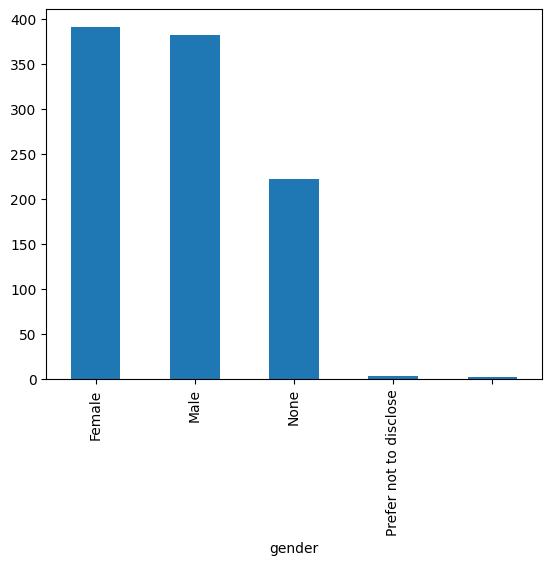

In [9]:
import matplotlib.pyplot as plt

category_counts = to_manipulate['gender'].value_counts()
print(to_manipulate['age'].mean())
# Plot the counts
category_counts.plot(kind='bar')

In [2]:
# Test mode
import json
import random

def sample_json_entry(file_path):
    """
    Samples one entry from a JSON file and returns the values of the 'id' and 'prompt' fields.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        dict: A dictionary containing the 'id' and 'prompt' fields of the sampled entry.
    """
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # Ensure the JSON is a list of entries
    if not isinstance(data, list):
        raise ValueError("The JSON file must contain a list of entries.")
    
    # Sample one entry at random
    random_entry = random.choice(data)
    
    # Extract 'id' and 'prompt' fields
    return random_entry.get("id"), random_entry.get("prompt")

# Test mode

id_, prompt = sample_json_entry("../results/parsed_prompts_tasks_x_subtopics.json")
print(id_)
print(prompt)
attributes_dict = get_prompt_attributes(prompt)
print(attributes_dict)